In [1]:
! pip install catboost
# import gdown
# gdown.download('https://drive.google.com/file/d/1yEdkfrQ8_yy7_wozo2cAvErELAofSTQL/view?usp=sharing', 'file.csv', quiet=False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00


**Вводная:**
Вам предоставлен датасает с некоторым набором данных, в которых заведомо известно, что существует некоторая взаимосвязь в данных.
Каждая строка описывает значения атрибутов некоторого объекта. Одна из колонок - зависимая переменная.
Необходимо построить алгоритм, который позволит прогнозировать значение зависимой переменной Y по вектору значений-атрибутов.
(ps - Возможно, что алгоритмом будет пользоваться дочка директора управления, которая плохо разбирается в программировании)

**Задача:**
Проанализировать атрибуты (далее - фичи):
- исследовать тип распределения каждой фичи, используя статистические методы
- составить заключение о физическом смысле зависимой переменной

Сформировать пул из не менее 3х решений основной задачи. Провести сравнительную оценку решений по критериям:
- скорость
- точность
- производительность
Выбрать наиболее эффективный (с обоснованием)

❕По каждому из указанных выше пунктов сформировать обоснование


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import os
import psutil

# df = pd.read_csv("file.csv")

path_to_file = './sample_data/test_ds_1.csv'
df = pd.read_csv(path_to_file)

In [3]:
# Функция для разделения строки на компонентыкомпоненты
def split_disk_info(disk_info):
    if 'TB' in disk_info:
        size = int(float(disk_info.split('TB')[0]) * 1024)
    else:
        size = int(disk_info.split('GB')[0])

    disk_type = 'SSD' if 'SSD' in disk_info else 'HDD'

    return pd.Series([size, disk_type])

In [4]:
df[['width', 'height']] = df['Resolution'].str.split('x', expand=True).astype(int)
df[['SizeGB', 'disk type']] = df['Storage'].apply(split_disk_info) # Это улучшело качество на 1%
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Resolution', 'Storage'])

## Небольшой анализ признаков

In [5]:
df.describe()

,RAM (GB),Screen Size (inch),Battery Life (hours),Weight (kg),Y,RAM latency,% defective devices (from 1000 pc),QDR benchamrk,width,height,SizeGB
count,11768.000000,11768.000000,11768.000000,11768.000000,11768.000000,11768.000000,11768.000000,11768.000000,11768.000000,11768.000000,11768.000000
mean,24.852821,15.212305,8.027855,2.341117,2183.571608,7.534925,10.006060,1238.943151,2426.974167,1365.079538,977.577158
std,21.762567,1.436997,2.305400,0.667921,1316.886132,0.551201,3.010088,431.853217,924.137138,519.934429,618.992798
min,4.000000,13.300000,4.000000,1.200000,279.570000,5.600000,-1.050000,-358.000000,1366.000000,768.000000,256.000000
25%,8.000000,14.000000,6.000000,1.760000,1272.045000,7.100000,7.980000,950.000000,1920.000000,1080.000000,512.000000
50%,16.000000,15.600000,8.000000,2.340000,1840.865000,7.500000,10.010000,1233.500000,2560.000000,1440.000000,1024.000000
75%,32.000000,16.000000,10.000000,2.910000,2698.370000,7.900000,12.010000,1531.250000,3840.000000,2160.000000,1024.000000
max,64.000000,17.300000,12.000000,3.500000,10807.880000,9.300000,22.400000,2944.000000,3840.000000,2160.000000,2048.000000


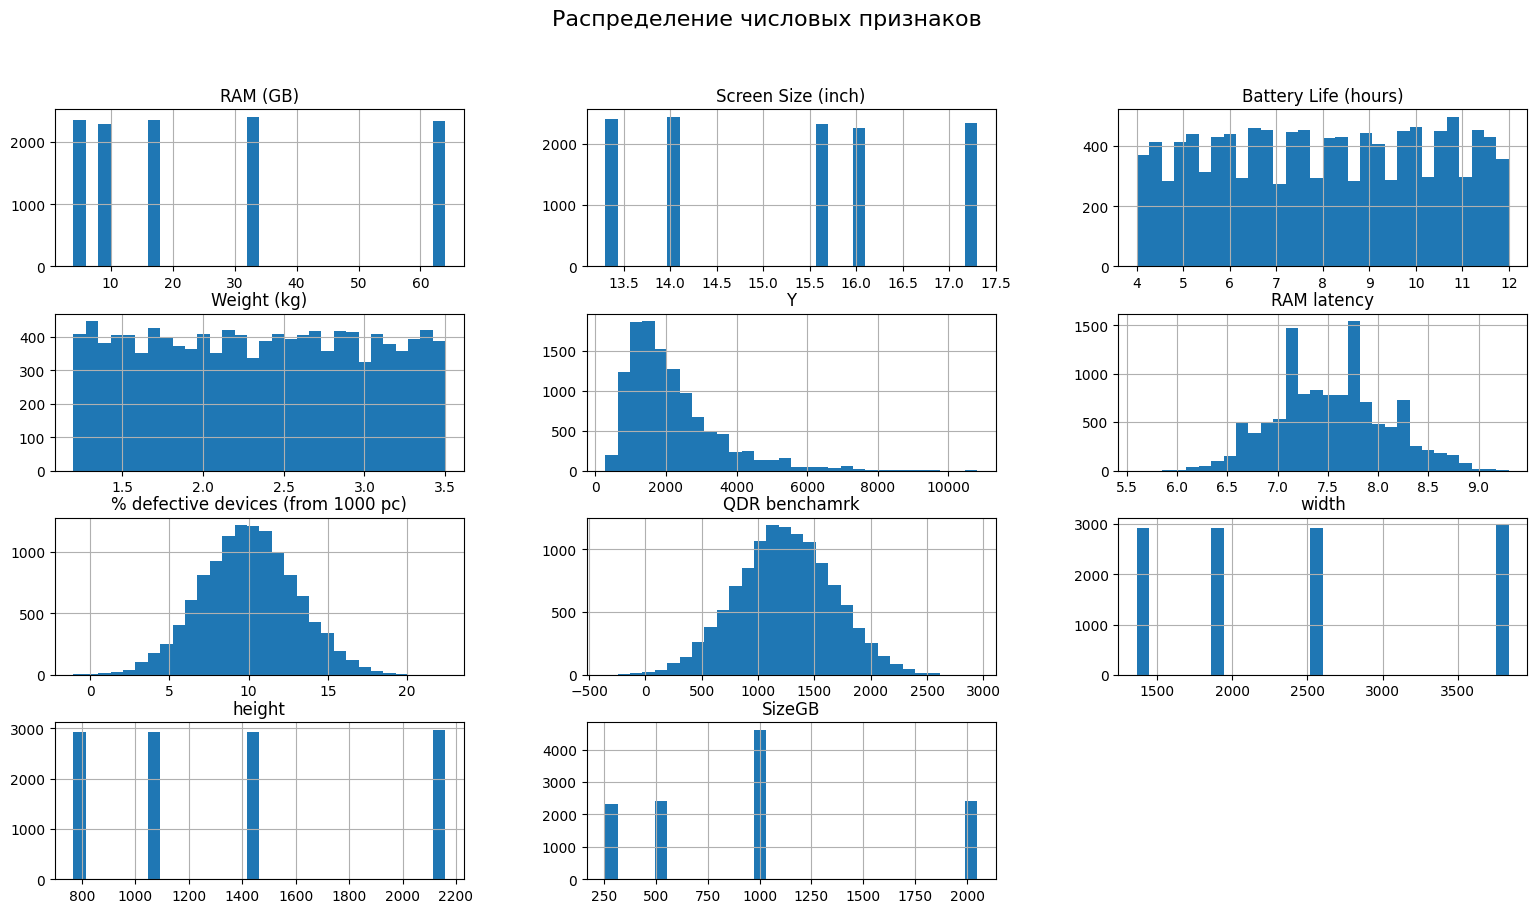

In [6]:
df.hist(figsize=(19, 10), bins=30)
plt.suptitle("Распределение числовых признаков", fontsize=16)
plt.show()

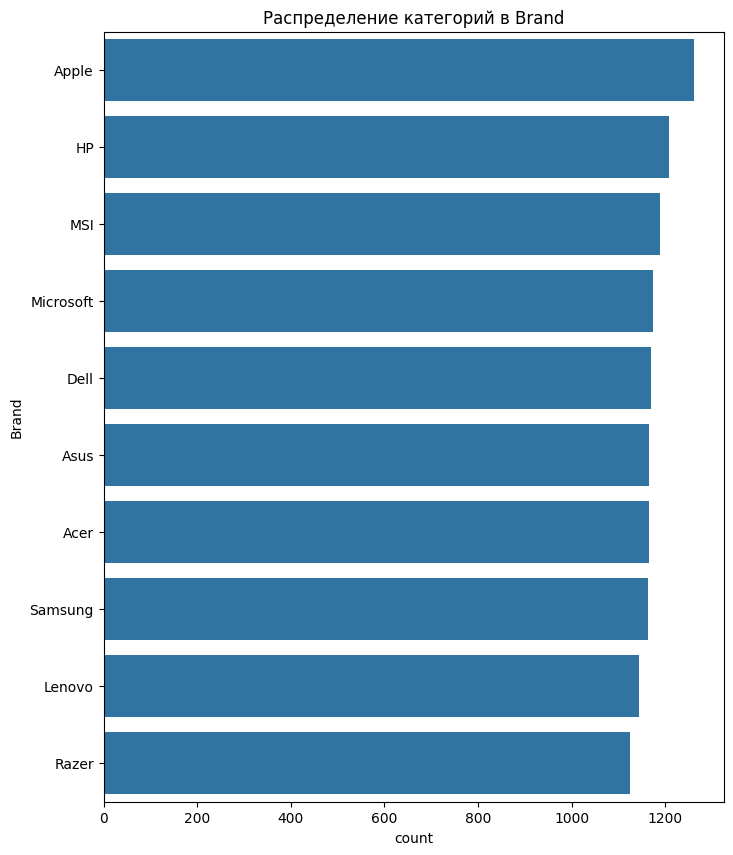

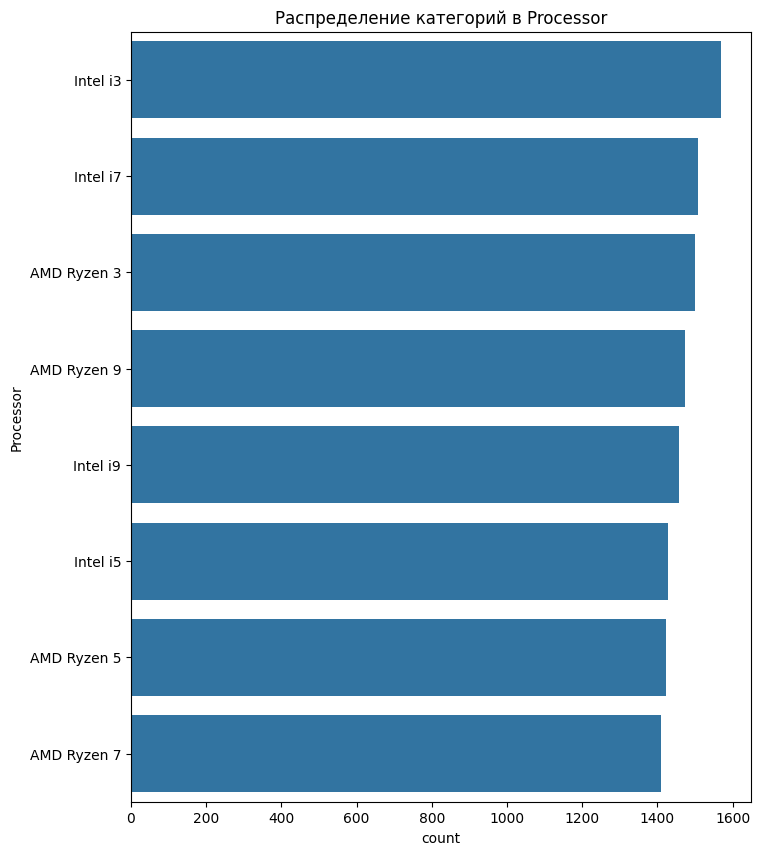

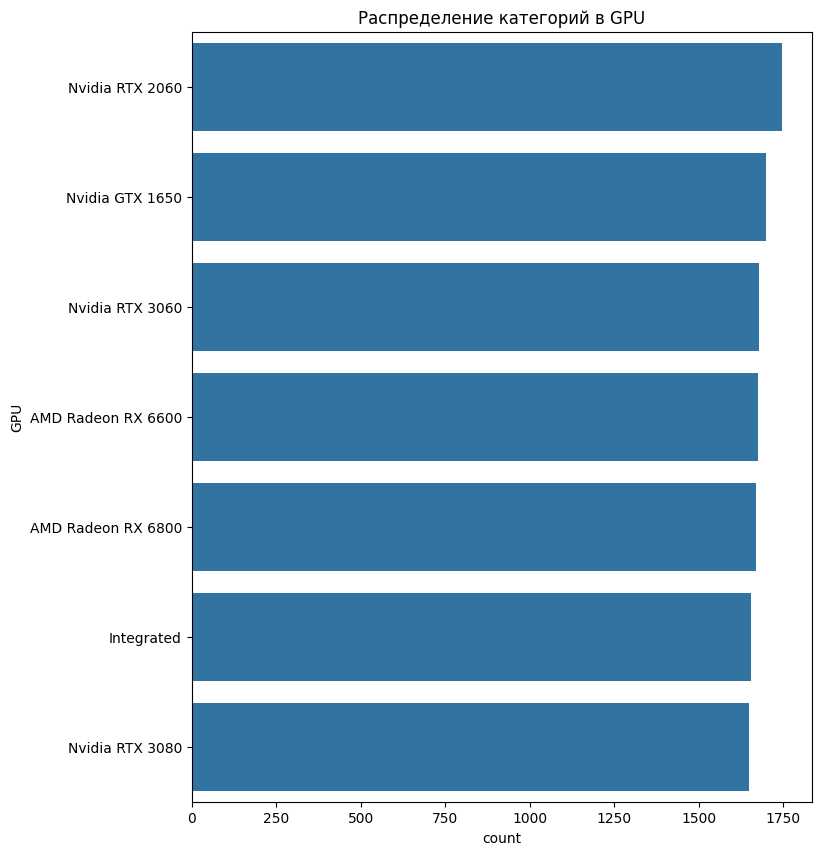

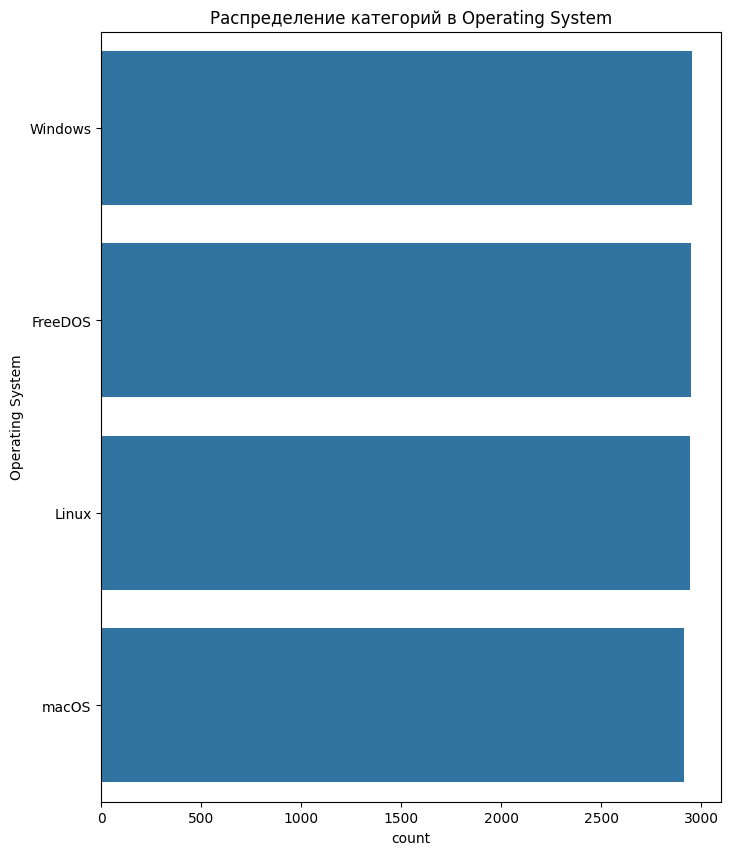

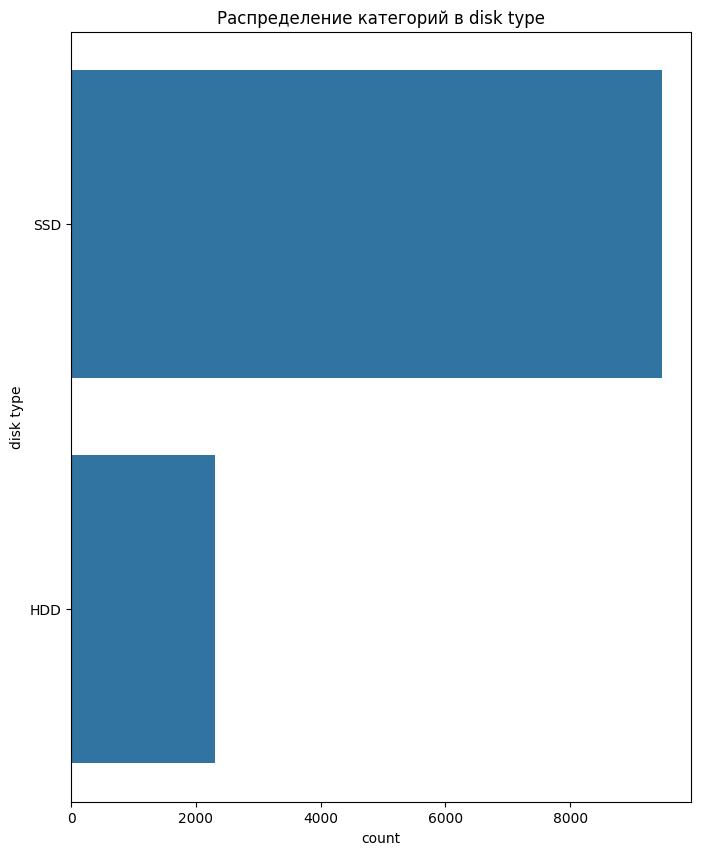

In [7]:
for col in df.select_dtypes(include=["object", "category"]):
    plt.figure(figsize=(8, 10))
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f"Распределение категорий в {col}")
    plt.show()

=> Несбалансированных категорий нет<br>
Если только (HDD: 1836, SSD: 7578)

По построению моделей был сделан вывод, какие признаки больше всего влияют на целевую переменную

Мною была обнаружена явная утечка данных, а именно один из признаков(RAM latency) равен натуральному логорифму целевой переменной(ln(Y)). Таким образом данный признак необходимо исключить, так как иначе модель получится слишком оптимистичной и нереалистичной для использования.


In [8]:
mainDF = df.copy()

In [9]:
df = df.drop(columns=['RAM latency', 'Operating System', '% defective devices (from 1000 pc)', \
                      'Weight (kg)', 'QDR benchamrk', 'Battery Life (hours)', 'SizeGB'])
data_object = df.select_dtypes('object').columns
object_features = list(data_object)

data_numeric = df.select_dtypes(include=['int64', 'float64']).columns
data_numeric = data_numeric[data_numeric != 'Y']
numeric_features = list(data_numeric)

print(object_features)
print(numeric_features)

['Brand', 'Processor', 'GPU', 'disk type']
['RAM (GB)', 'Screen Size (inch)', 'width', 'height']


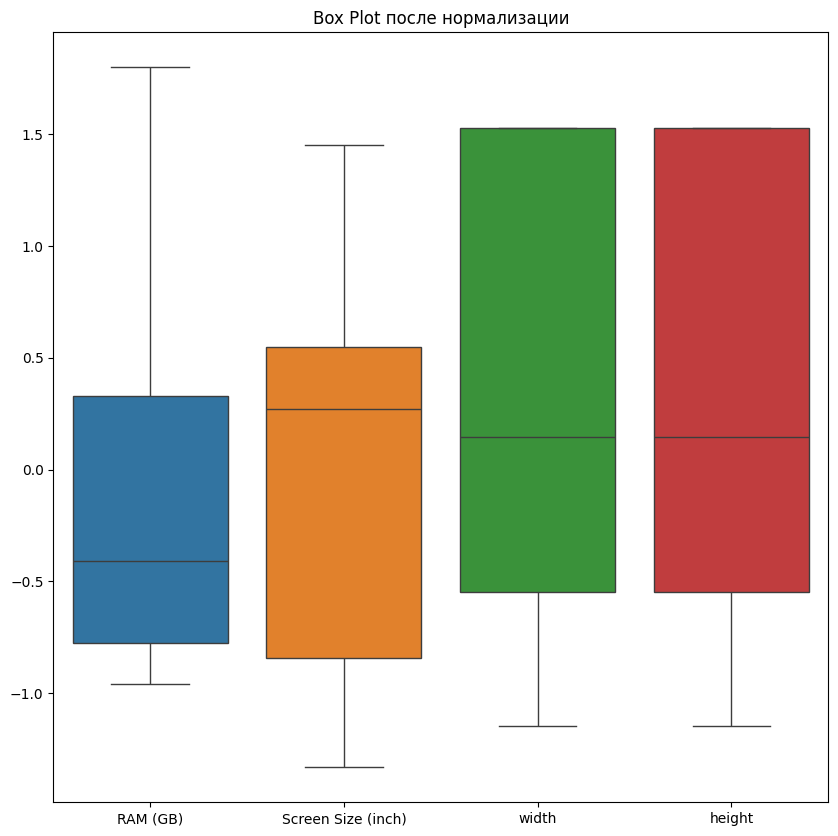

In [10]:
scaler = StandardScaler()

X_normalized = scaler.fit_transform(df[data_numeric])
X_normalized = pd.DataFrame(X_normalized, columns=data_numeric)
plt.figure(figsize=(10, 10))
sns.boxplot(data=X_normalized)
plt.title('Box Plot после нормализации')
plt.show()

=> Шумовых данных нет


In [11]:
X = df.drop('Y', axis=1)
Y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Модель

In [12]:
test_catboost_model = CatBoostRegressor(verbose=0)

param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3],
    'depth': [6, 8, 10],
}

grid_search = GridSearchCV(test_catboost_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train, cat_features=object_features)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

print("Лучшие параметры: ", grid_search.best_params_)
print("Лучшая MAE на кросс-валидации: ", -grid_search.best_score_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Лучшие параметры:  {'depth': 6, 'iterations': 300, 'learning_rate': 0.2}
Лучшая MAE на кросс-валидации:  82.02423800605315


In [13]:
%%time

cpu_before = psutil.cpu_percent(interval=1)

CatBoost_model = CatBoostRegressor(**grid_search.best_params_, verbose=0)

CatBoost_model.fit(X_train, y_train, cat_features=object_features)

cpu_after = psutil.cpu_percent(interval=1)

y_pred = CatBoost_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"CPU used: {cpu_after}%")

MAE: 79.09347741742509
R2: 0.9949734395363429
CPU used: 21.7%
CPU times: user 2.87 s, sys: 330 ms, total: 3.2 s
Wall time: 4.51 s


Лучшие параметры:  {'depth': 6, 'iterations': 200, 'learning_rate': 0.2}<br>
Лучшая MAE на кросс-валидации:  82.0<br>
**MAE**: 79.1<br>
**R2**: 0.995<br>
Wall time: 4.2 s


## Немного анализа атрибутов благодаря CatBoost

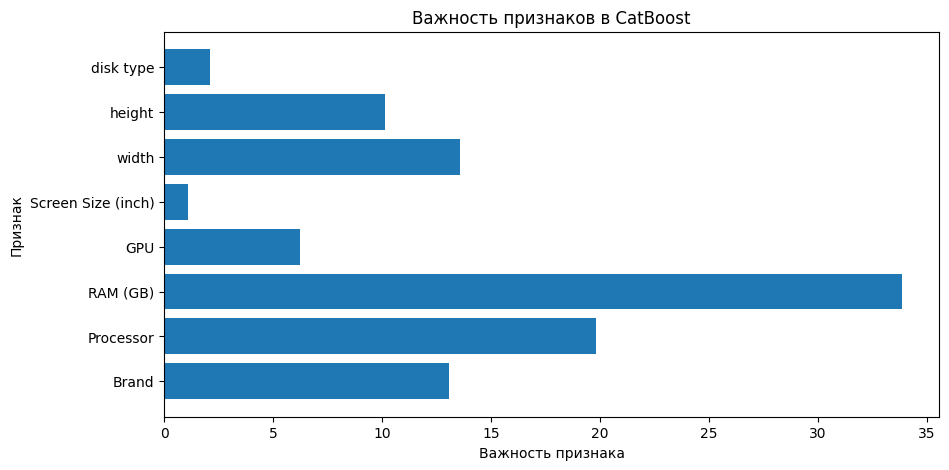

In [14]:
feature_importance = CatBoost_model.get_feature_importance()
plt.figure(figsize=(10, 5))
plt.barh(X_train.columns, feature_importance)
plt.xlabel("Важность признака")
plt.ylabel("Признак")
plt.title("Важность признаков в CatBoost")
plt.show()

# Теперь OneHotEncoding + другие модели

In [15]:
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
enc.fit(X_train[object_features])

# Преобразование категориальных признаков
X_train_ohe = enc.transform(X_train[object_features])
X_test_ohe = enc.transform(X_test[object_features])

X_train_number = np.array(X_train.select_dtypes('number'))
X_test_number = np.array(X_test.select_dtypes('number'))

# Масштабирование числовых признаков
scaler = StandardScaler()
scaler.fit(X_train_number)

X_train_number_scaled = scaler.transform(X_train_number)
X_test_number_scaled = scaler.transform(X_test_number)

# Объединение числовых и категориальных признаков
X_train_new = np.hstack((X_train_number_scaled, X_train_ohe))
X_test_new = np.hstack((X_test_number_scaled, X_test_ohe))

Предвaрительно был так же проведен GridSearch для поиска наилучших гиперпараметров.<br>
'n_estimators': [100, 200, 300],  # Количество деревьев<br>
    'max_depth': [None, 5, 10],  # Глубина деревьев<br>
    'min_samples_split': [2, 5, 10],  # Минимальное количество образцов для разделения<br>
    'min_samples_leaf': [1, 2, 4]  # Минимальное количество образцов в листе <br>
Но лучшая модель оказалась та, у которой наибольшее количество n_estimators(деревьев). Поэтому подберем такую, что время и качество будут в совокупности давать максимальную эффективность


In [16]:
%%time

cpu_before = psutil.cpu_percent(interval=1)

forest_model = RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=42)
forest_model.fit(X_train_new, y_train)

cpu_after = psutil.cpu_percent(interval=1)

y_pred = forest_model.predict(X_test_new)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.6f}")
print(f"R2: {r2:.6f}")
print(f"CPU used: {cpu_after}%")

MAE: 112.555609
R2: 0.984921
CPU used: 2.5%
CPU times: user 23.2 s, sys: 432 ms, total: 23.6 s
Wall time: 19.9 s


Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}<br>
Лучшая MAE на кросс-валидации: 120.1<br>
**MAE**: 112.56<br>
**R2**: 0.985<br>
Wall time: 19.4 s

## Попробуем какую то простую модель регрессии

In [17]:
%%time

Linear_model = LinearRegression()

Linear_model.fit(X_train_new, y_train)

y_pred = Linear_model.predict(X_test_new)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"R2: {r2}")

MAE: 320.7082554594241
R2: 0.8795705430446144
CPU times: user 28.7 ms, sys: 9.8 ms, total: 38.5 ms
Wall time: 43.6 ms


In [18]:
%%time

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_new, y_train)
y_pred = lasso_model.predict(X_test_new)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"R2: {r2}")

MAE: 320.1441186336293
R2: 0.8795942465898076
CPU times: user 180 ms, sys: 40.8 ms, total: 221 ms
Wall time: 131 ms


In [19]:
%%time

ridge_model = Ridge(alpha=1.0)

ridge_model.fit(X_train_new, y_train)

y_pred = ridge_model.predict(X_test_new)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"R2: {r2}")

MAE: 320.21064925302824
R2: 0.879582275372241
CPU times: user 7.48 ms, sys: 13.9 ms, total: 21.4 ms
Wall time: 12.9 ms


In [20]:
Elastic_model = ElasticNet(max_iter=10000)

param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],  # Сила регуляризации
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]  # Соотношение L1/L2 (0 = Ridge, 1 = Lasso)
}

grid_search = GridSearchCV(estimator=Elastic_model, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', cv=5)

grid_search.fit(X_train_new, y_train)

print(f"Лучшие гиперпараметры: {grid_search.best_params_}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.367e+08, tolerance: 1.290e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.282e+08, tolerance: 1.298e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Лучшие гиперпараметры: {'alpha': 0.1, 'l1_ratio': 0.75}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.537e+09, tolerance: 1.318e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [21]:
%%time


cpu_before = psutil.cpu_percent(interval=1)

elastic_model = ElasticNet(**grid_search.best_params_)

elastic_model.fit(X_train_new, y_train)

cpu_after = psutil.cpu_percent(interval=1)

y_pred = elastic_model.predict(X_test_new)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"CPU used: {cpu_after}%")

MAE: 308.86811531584436
R2: 0.8696842738806352
CPU used: 2.5%
CPU times: user 55.7 ms, sys: 54.5 ms, total: 110 ms
Wall time: 2.04 s


## Полиноминальная регрессия

In [22]:
%%time

from sklearn.preprocessing import PolynomialFeatures

degree = 3

# Преобразование признаков в полиномиальные
poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train_new)
X_test_poly = poly.transform(X_test_new)

cpu_before = psutil.cpu_percent(interval=1)

model = LinearRegression()
model.fit(X_train_poly, y_train)

cpu_after = psutil.cpu_percent(interval=1)

y_pred = model.predict(X_test_poly)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"CPU used: {cpu_after}%")

MAE: 83.41698970824282
R2: 0.9943114598597376
CPU used: 8.5%
CPU times: user 6min 14s, sys: 2.46 s, total: 6min 16s
Wall time: 3min 51s


MAE: 83.42<br>
R2: 0.9943<br>
Wall time: 4min 28s


<table>
    <thead>
        <tr>
            <th>Модель</th>
            <th>Скорость</th>
            <th>Производительность</th>
            <th>Точность</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>CatBoost</td>
            <td>средняя</td>
            <td>средне-высокая</td>
            <td>высокая</td>
        </tr>
        <tr>
            <td>RandomForest</td>
            <td>низкая</td>
            <td>выше среднего</td>
            <td>средне-высокая</td>
        </tr>
        <tr>
            <td>ElasticNet</td>
            <td>высокая</td>
            <td>средняя</td>
            <td>высокая</td>
        </tr>
        <tr>
            <td>Polynomial</td>
            <td>низкая</td>
            <td>средне-высокая</td>
            <td>низкая</td>
        </tr>
    </tbody>
</table>

=> самой эффективной моделью является CatBoost

## Но если RAM_latency является основополагающим признаком для предсказания Y и никакой утечки и ошибки в Датасете нет!

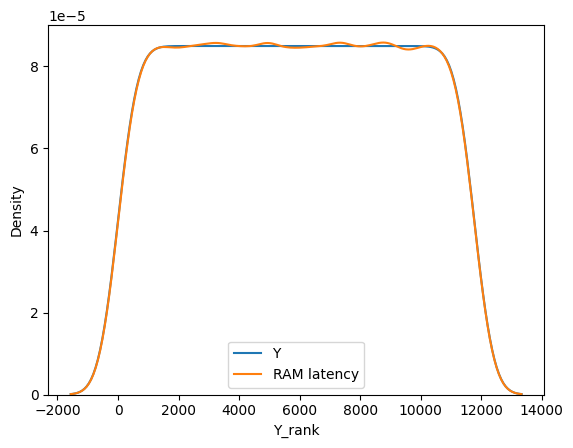

In [23]:
tmpDF = mainDF.copy()
tmpDF['Y_rank'] = tmpDF['Y'].rank()
tmpDF['latency_rank'] = tmpDF['RAM latency'].rank()
sns.kdeplot(tmpDF['Y_rank'], label='Y')
sns.kdeplot(tmpDF['latency_rank'], label='RAM latency')
plt.legend()
plt.show()


=> Да, Y и RAM_latency сильно похожи

In [24]:
mainDF = mainDF[['RAM latency', 'RAM (GB)', 'width', 'Processor', 'Brand', 'Y']]
main_data_object = mainDF.select_dtypes('object').columns
main_object_features = list(main_data_object)

main_data_numeric = mainDF.select_dtypes(include=['int64', 'float64']).columns
main_data_numeric = main_data_numeric[main_data_numeric != 'Y']
main_numeric_features = list(main_data_numeric)

print(main_object_features)
print(main_numeric_features)

['Processor', 'Brand']
['RAM latency', 'RAM (GB)', 'width']


# Модели

In [25]:
X = mainDF.drop('Y', axis=1)
Y = mainDF['Y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

CatBoost

In [26]:
# test_catboost_model = CatBoostRegressor(verbose=0)

# param_grid = {
#     'iterations': [100, 300, 400],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'depth': [4, 6, 8],
# }

# grid_search = GridSearchCV(test_catboost_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

# grid_search.fit(X_train, y_train, cat_features=main_object_features)

# # best_model = grid_search.best_estimator_
# # y_pred = best_model.predict(X_test)

# print("Лучшие параметры: ", grid_search.best_params_)
# print("Лучшая MAE на кросс-валидации: ", -grid_search.best_score_)

Лучшие гиперпараметры это {'depth': 4, 'iterations': 400, 'learning_rate': 0.2}<br>
это было получено в результате GridSearch анализа, где MAE на кросс валидации = 51.9

In [27]:
%%time

cpu_before = psutil.cpu_percent(interval=1)

CatBoost_main_model = CatBoostRegressor(depth=4, iterations=400, learning_rate=0.2, verbose=0)

CatBoost_main_model.fit(X_train, y_train, cat_features=main_object_features)

cpu_after = psutil.cpu_percent(interval=1)

y_pred = CatBoost_main_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"CPU used: {cpu_after}%")

MAE: 51.70836315468365
R2: 0.9974252838274972
CPU used: 55.3%
CPU times: user 2.27 s, sys: 199 ms, total: 2.47 s
Wall time: 3.42 s


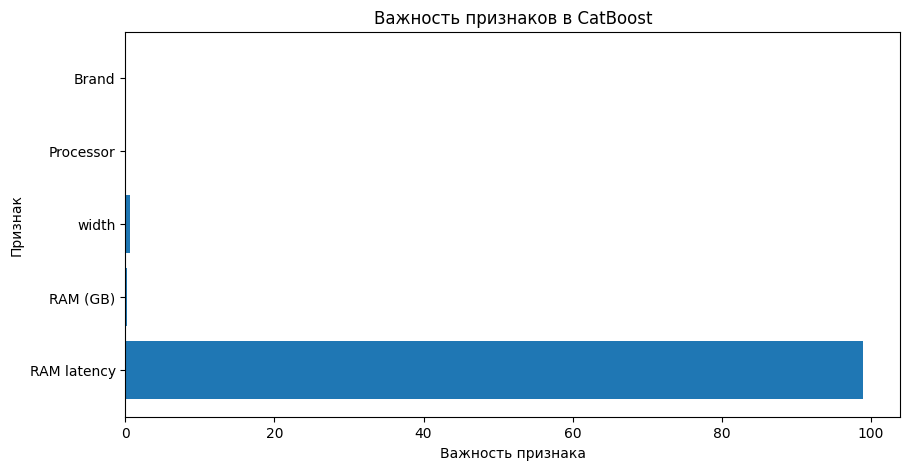

In [28]:
main_feature_importance = CatBoost_main_model.get_feature_importance()
plt.figure(figsize=(10, 5))
plt.barh(X_train.columns, main_feature_importance)
plt.xlabel("Важность признака")
plt.ylabel("Признак")
plt.title("Важность признаков в CatBoost")
plt.show()

другие модели

In [29]:
X = mainDF.drop('Y', axis=1)
Y = mainDF['Y']
Y_log = np.log(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y_log, test_size=0.2, random_state=42)


In [30]:
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
enc.fit(X_train[main_object_features])

X_train_ohe = enc.transform(X_train[main_object_features])
X_test_ohe = enc.transform(X_test[main_object_features])

X_train_number = np.array(X_train.select_dtypes('number'))
X_test_number = np.array(X_test.select_dtypes('number'))

scaler = StandardScaler()
scaler.fit(X_train_number)

X_train_number_scaled = scaler.transform(X_train_number)
X_test_number_scaled = scaler.transform(X_test_number)

X_train_main = np.hstack((X_train_number_scaled, X_train_ohe))
X_test_main = np.hstack((X_test_number_scaled, X_test_ohe))

Линейная регрессия на логарифмированную целевую переменную

In [31]:
%%time
main_Linear_model = LinearRegression()
main_Linear_model.fit(X_train_main, y_train)

y_pred_log = main_Linear_model.predict(X_test_main)
y_pred = np.exp(y_pred_log)

mae = mean_absolute_error(np.exp(y_test), y_pred)
r2 = r2_score(np.exp(y_test), y_pred)

print(f"MAE: {mae}")
print(f"R2: {r2}")


MAE: 52.34311510947646
R2: 0.9973799080771427
CPU times: user 23.5 ms, sys: 6.85 ms, total: 30.4 ms
Wall time: 29 ms


RandomForestRegression

In [32]:
# from sklearn.metrics import make_scorer
# param_grid = {
#     'n_estimators': [200, 300],  # Количество деревьев
#     'max_depth': [None, 20],  # Максимальная глубина дерева
# }
# rf = RandomForestRegressor(random_state=42, verbose=0)
# scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=mean_absolute_error, cv=5, n_jobs=-1, verbose=2)

# # Выполняем поиск по сетке
# grid_search.fit(X_train_main, y_train)

# # Выводим лучшие параметры
# print("Лучшие параметры:", grid_search.best_params_)
# print("Лучшая оценка MAE: ", -grid_search.best_score_)


Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}



In [33]:
%%time

main_forest_model = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)
main_forest_model.fit(X_train_main, y_train)

cpu_after = psutil.cpu_percent(interval=1)

y_pred = main_forest_model.predict(X_test_main)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

MAE: 0.0261
R2: 0.9968
CPU times: user 11.7 s, sys: 233 ms, total: 12 s
Wall time: 7.47 s



<table>
    <thead>
        <tr>
            <th>Модель</th>
            <th>Скорость</th>
            <th>Производительность</th>
            <th>Точность</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>main_CatBoost</td>
            <td>средняя</td>
            <td>средне-высокая</td>
            <td>высокая</td>
        </tr>
        <tr>
            <td>main_RandomForest</td>
            <td>средне-высокая</td>
            <td>средняя</td>
            <td>выше среднего</td>
        </tr>
        <tr>
            <td>main_LinearModel</td>
            <td>высокая</td>
            <td>высокая</td>
            <td>высокая</td>
        </tr>
    </tbody>
</table>

=> самой эффективной моделью является main_LinearModel